# <center> Neural Network OPF (Optimal Power Flow) </center>

## Importing necessary packages


In [16]:
import torch  # PyTorch library for building and training neural networks
import torch.nn as nn  # Used to create neural networks
import torch.optim as optim  # Adam optimizer for training the model
import pandas as pd  # For working with DataFrames
from sklearn.model_selection import train_test_split  # To split data into training and testing sets
from sklearn.preprocessing import MinMaxScaler  # For scaling data using Min-Max scaling
from sklearn.preprocessing import StandardScaler  # For scaling data using StandardScaler
import matplotlib.pyplot as plt  # To create plots and visualize data
from torch.utils.data import TensorDataset, DataLoader  # To create datasets and divide data into batches
import numpy as np  # For working with matrices and numerical operations
import joblib  # To save and load data scaling transformations
import random  # To generate random numbers
import h5py  # To work with HDF5 file format (for large datasets)


The data is extracted from directories where it is located. For training, the inputs are the demands obtained from MATPOWER (loaded lines),
and the outputs are the Beta terms obtained through optimization.

In [17]:
# Directory of input and output data

# Select the system name corresponding to the power grid case being analyzed
# system_name = "pglib_opf_case14_ieee"
# system_name = "pglib_opf_case30_ieee"
system_name = "pglib_opf_case57_ieee"
# system_name = "pglib_opf_case118_ieee2"
# system_name = "pglib_opf_case300_ieee"

# Construct the file name with the selected system
name_file = 'Generation_MPCE_' + system_name + '.mat'

# Open the .mat file containing the input/output data
with h5py.File(name_file, 'r') as file:
    # List all the keys in the .mat file (uncomment to print)
    # print("Keys in the .mat file:", list(file.keys()))

    # Load Beta values (outputs) from the file
    df_outputs = np.array(file['Beta'][:])
    
    # Load Demand values (inputs) from the file
    df_inputs = np.array(file['Demand'][:])

    # Load Probe Demand values from the file
    df_inputs_PROBE = np.array(file['Demand_Probe'][:])

# Transpose the outputs and inputs to match the required format for the neural network
df_outputs = np.transpose(df_outputs)  # Transpose Beta values (outputs)
df_inputs = np.transpose(df_inputs)  # Transpose Demand values (inputs)
df_inputs_PROBE = np.transpose(df_inputs_PROBE)  # Transpose Probe Demand values (inputs)

# Print the shapes of the outputs and inputs to verify their dimensions
print(df_outputs.shape)  # Outputs (Beta values) shape
print(df_inputs.shape)  # Inputs (Demand values) shape


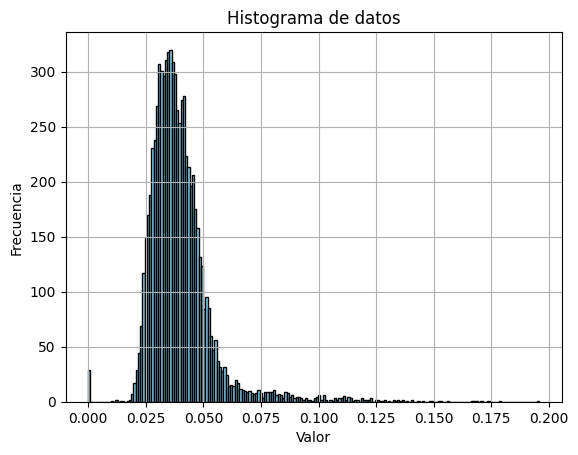

In [21]:

samples = 7500 # Define the number of samples to use

# Select the first 7500 samples from inputs and outputs
df_inputs = df_inputs[0:samples, :]
df_outputs = df_outputs[0:samples, :]

plt.hist(df_outputs[:,9], bins=200, color='skyblue', edgecolor='black')
plt.xlabel('Value') 
plt.ylabel('Frequency')
plt.title('Data Histogram')
plt.grid(True)
plt.show()

In [22]:
# Data processing:
# Convert the input and output data into tensors
X = torch.tensor(df_inputs, dtype=torch.float32)  # Inputs
y = torch.tensor(df_outputs, dtype=torch.float32)  # Outputs

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, shuffle=True)

# Set the batch size for training and testing
batch_size = 64

# Create datasets for training and testing
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Create data loaders to load data in batches
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [23]:
# Neural Network Structure:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        # Define the first layer: Input size is the number of features in X_train, output size is 512 neurons
        self.layer1 = nn.Linear(X_train.shape[1], 512)
        
        # Define the second layer: Input size is 512 neurons, output size is 256 neurons
        self.layer2 = nn.Linear(512, 256)
        
        # Define the third layer: Input size is 256 neurons, output size is the number of features in y_train
        self.layer3 = nn.Linear(256, y_train.shape[1])

    # Define the forward pass
    def forward(self, x):
        # Apply ReLU activation to each layer
        x = torch.relu(self.layer1(x))  # First layer
        x = torch.relu(self.layer2(x))  # Second layer
        x = torch.relu(self.layer3(x))  # Third layer
        return x


In [24]:
# Device configuration (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, otherwise CPU
net = NeuralNetwork().to(device)  # Move the neural network to the selected device

# Define the loss function for the neural network, in this case, using Mean Squared Error (MSE)
def criterion(predictions, labels, inputs):
    loss = nn.MSELoss()  # Mean Squared Error loss function
    # Compute the sum of predictions and labels multiplied by inputs
    sum1 = torch.sum(predictions * inputs, dim=1)
    sum2 = torch.sum(labels * inputs, dim=1)
    
    # Mean Squared Error term (MSE)
    mse_term = loss(predictions * inputs, labels * inputs) + 1e1 * loss(sum1, sum2)

    total_loss = mse_term  # Total loss is the MSE term
    
    return total_loss

# Define the optimizer (Adam optimizer with learning rate and weight decay)
optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay=1e-4)


In [26]:
# Set the training criteria
epochs = 2000  # Number of training epochs
min_val_loss = float('inf')  # Initialize the minimum validation loss as infinity
patience = 10  # Number of epochs to wait before early stopping
counter = 0  # Counter for early stopping
train_losses = []  # List to store training losses over epochs
val_losses = []  # List to store validation losses over epochs

# Training loop
for epoch in range(epochs):
    net.train()  # Set the network to training mode
    running_loss = 0.0  # Initialize running loss for this epoch
    
    # Iterate through the training data batches
    for inputs, targets in train_loader:  # Extract data from the train loader
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the selected device (CPU/GPU)
        
        optimizer.zero_grad()  # Clear gradients from the previous step
        outputs = net(inputs)  # Forward pass through the network
        inputstrain = inputs[:, 0:57]  # Select the first 57 columns as inputs
        
        loss = criterion(outputs, targets, inputstrain)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the model parameters
        running_loss += loss.item()  # Accumulate the loss

    avg_train_loss = running_loss / len(train_loader)  # Compute the average training loss for the epoch

    # Validation step on the test data
    net.eval()  # Set the network to evaluation mode
    val_loss = 0.0  # Initialize validation loss
    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, targets in test_loader:  # Extract data from the test loader
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the selected device
            outputs = net(inputs)  # Forward pass through the network
            inputstest = inputs[:, 0:57]  
            loss = criterion(outputs, targets, inputstest)  # Compute the loss
            val_loss += loss.item()  # Accumulate the validation loss

    avg_val_loss = val_loss / len(test_loader)  # Compute the average validation loss for the epoch
    train_losses.append(avg_train_loss)  # Store the training loss
    val_losses.append(avg_val_loss)  # Store the validation loss
    
    # Early Stopping implementation
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss  # Update the minimum validation loss
        counter = 0  # Reset the early stopping counter
        torch.save(net.state_dict(), 'best_model.pth')  # Save the best model
    else:
        counter += 1  # Increment the early stopping counter
        if counter >= patience:  # If the counter exceeds patience, stop training
            print(f"Early stopping triggered at epoch {epoch+1}")
            break  # Exit the training loop

    # Print the training and validation losses for this epoch
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.5f}, Val Loss: {avg_val_loss:.5f}')


Epoch [1/2000], Train Loss: 1603.89891, Val Loss: 1539.13557
Epoch [2/2000], Train Loss: 1482.83514, Val Loss: 1404.35577
Epoch [3/2000], Train Loss: 1323.49928, Val Loss: 1222.69977
Epoch [4/2000], Train Loss: 1107.91574, Val Loss: 954.48124
Epoch [5/2000], Train Loss: 805.43520, Val Loss: 648.40049
Epoch [6/2000], Train Loss: 512.43075, Val Loss: 378.08903
Epoch [7/2000], Train Loss: 273.34567, Val Loss: 179.30328
Epoch [8/2000], Train Loss: 117.00618, Val Loss: 66.89207
Epoch [9/2000], Train Loss: 40.60402, Val Loss: 22.52961
Epoch [10/2000], Train Loss: 14.84998, Val Loss: 10.50785
Epoch [11/2000], Train Loss: 8.92135, Val Loss: 8.43345
Epoch [12/2000], Train Loss: 7.94960, Val Loss: 8.11420
Epoch [13/2000], Train Loss: 7.79115, Val Loss: 8.02209
Epoch [14/2000], Train Loss: 7.74255, Val Loss: 7.98150
Epoch [15/2000], Train Loss: 7.68004, Val Loss: 7.89885
Epoch [16/2000], Train Loss: 7.62995, Val Loss: 7.81321
Epoch [17/2000], Train Loss: 7.57908, Val Loss: 7.76458
Epoch [18/2000]

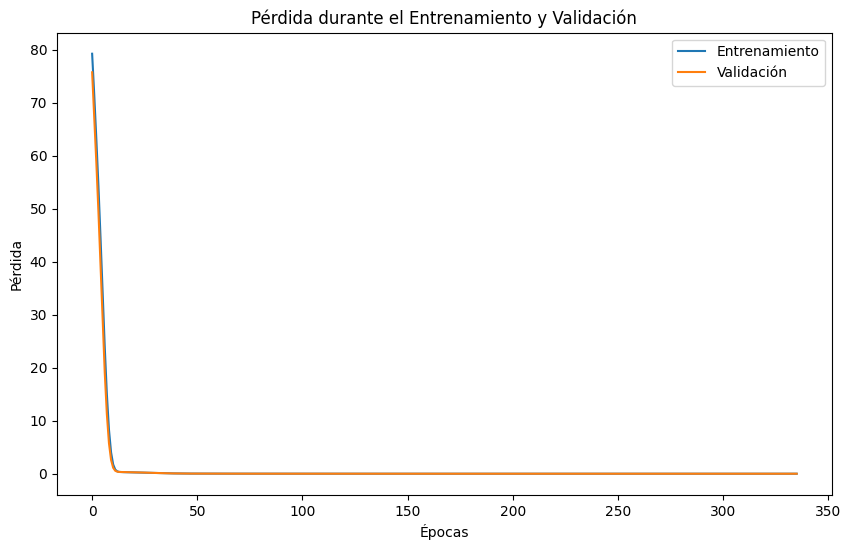

In [ ]:
# Plot of the losses during each epoch
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training')  
plt.plot(val_losses, label='Validation') 
plt.title('Loss during Training and Validation')  
plt.xlabel('Epochs')  
plt.ylabel('Loss') 
plt.legend() 
plt.show()  

Una vez entrenado y guardado el modelo se procede a cargar el mejor modelo de entrenamiento, para probar con todos las entradas que se tiene a fin de obtener los betas arrojados por la red entrenada. Se verifica que la estructura del modelo sea la misma a la entrenada para evitar confusión a la hora de cargar el modelo.

In [ ]:
# Load the saved model
net = NeuralNetwork().to(device)  # Create a new instance of the neural network and move it to the selected device
net.load_state_dict(torch.load('best_model.pth'))  # Load the saved model parameters
net.eval()  # Set the model to evaluation mode (disables dropout and batch normalization)

# Import inputs for predicting outputs
NewInput = torch.tensor(df_inputs_PROBE, dtype=torch.float32)  # Convert the new input data (PROBE) into a tensor

# Make predictions with the model (no gradient calculation needed)
with torch.no_grad():
    Newoutput = net(NewInput)  # Predict new outputs using the neural network

# Print the shape of the model output
print("Model Output Shape:", Newoutput.shape)

# Save the new Beta values as a CSV file
BetasNuevos = pd.DataFrame(Newoutput)
name_beta = 'Beta_nn_' + system_name + '.csv'
BetasNuevos.to_csv(name_beta, index=False)  # Save the DataFrame to a CSV file

# Print the first row of the predicted Betas
print(BetasNuevos.iloc[0, :])

# Print the summary statistics of the predicted Betas
print(BetasNuevos.describe())


NeuralNetwork(
  (layer1): Linear(in_features=60, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=30, bias=True)
)